In [3]:
from control import *
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# kp, ki, kd
# 0.9775171065493646, 0.9775171065493646, 999.0224828934506
# 4.887585532746823, 275.65982404692085, 984.3597262952102
# 7.820136852394917, 85.04398826979472, 936.4613880742913
# 31.28054740957967, 44.965786901270775, 956.989247311828
# 8.79765395894428, 75.26881720430107, 947.2140762463343
kp = 2
ki = 2
kd = 2

In [5]:
num = [0.9387, 0.0006683]
den = [1, 0.6274, 0.0004594]
plant = tf(num, den)
pid = tf([kd,kp,ki], [1,0])

In [6]:
plant


   0.9387 s + 0.0006683
--------------------------
s^2 + 0.6274 s + 0.0004594

In [149]:
sys = feedback(pid, plant, sign=1)

In [150]:
#sysd = sys.sample(Ts=0.025, method='zoh', alpha=None)

In [151]:
sys


2 s^4 + 3.255 s^3 + 3.256 s^2 + 1.256 s + 0.0009188
---------------------------------------------------
    -0.8774 s^3 - 1.251 s^2 - 1.878 s - 0.001337

In [152]:
time = np.arange(0,90)

In [153]:
sys1 = feedback(pid*plant, 1)
sys1d = sys1.sample(Ts=0.025, method='zoh', alpha=None)
sys1d


0.6525 z^3 - 1.941 z^2 + 1.925 z - 0.6364
-----------------------------------------
    z^3 - 2.978 z^2 + 2.957 z - 0.9785

dt = 0.025

In [158]:
len(s)

90

<function matplotlib.pyplot.show>

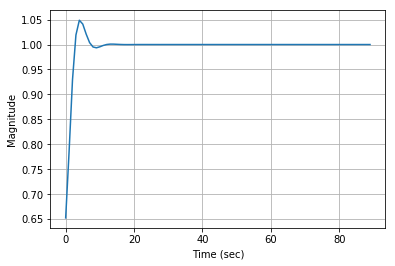

In [159]:
# PID compensated Step Response
t, s = step_response(sys1,T=time)
target = np.linspace(1, 1, num=len(t))
plt.figure()
#plt.plot(t,s,t,target)
plt.plot(t,s)
#plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

In [45]:
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2*np.pi*t)

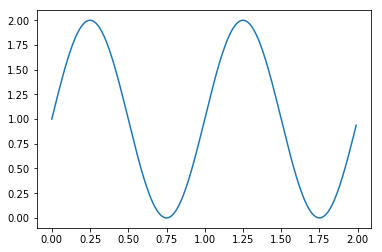

In [46]:
plt.plot(t, s)

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from control import *

In [160]:
# Plant
num = [1]
den = [64,9.6,0.48,0.008]
G = tf(num, den)

# Plant Step Response
t, s = step_response(G)

#PID Controller
kp = 0.0361 
ki = 0.000731
kd = 0.6999

pid_num = [kd, kp, ki]
pid_den = [1, 0]
C = tf(pid_num,pid_den)

# System
T = feedback(C*G,1)

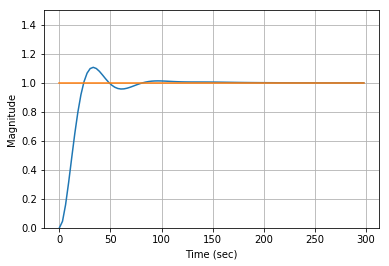

In [161]:
# PID compensated Step Response
t, s = step_response(T)
target = np.linspace(1, 1, num=len(t))
plt.figure()
plt.plot(t,s,t,target)
#plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

error = target - s

In [7]:
import matplotlib
import numpy
from control import *
import math

In [8]:
from deap import base, creator
# Crear clase FITNESS: ( Nombre de la clase, Delegando la clase como fitness, Posibles valores min y max del fitness )
creator.create("ControllerFitness", base.Fitness, weights=(-1.0,)) # ES 1 POSITIVO PORQUE SE BUSCA MAXXIMIZAR, Y PARA ENTENDER ESTO VERIFICAR LO QUE RETORNA LA FUNCIÓN QUE EVALUA EL PID!!!

# Crear clase CROMOSOMA: ( Nombre de la clase, type de los valores de la clase, Establecer fitness con la clase anterior )
creator.create("Controller", list, fitness=creator.ControllerFitness)

In [9]:
import random
from deap import tools

IND_SIZE = 33 # ki bits + kp bits + kd bits

# Functions to initialize populations from individuals

toolbox = base.Toolbox()

# Crear el ATRIBUTO de cromosomas ( Nombre del registro para el toolbox, Función para crear un cromosoma aleatorio )
toolbox.register("bit_attribute", random.randint, 0, 1) # random.choice, '10')

# Crear el CROMOSOMA ( Nombre del registro, , La clase cromosoma, La clase atributo, Tamaño de la población )
# Cuando se llame a toolbox.individual(), este llamará a tool.initRepeat()
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)

# Crear la POBLACIÓN ( Nombre del registro, , Type del cromosoma, El cromosoma )
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

In [10]:
ind = toolbox.controller()

In [40]:
def evaluate(controller):
    controller = ''.join(map(str,controller))
    
    # PID controller
    _kp = int(controller[0:11],2)
    _ki = int(controller[11:22],2)
    _kd = int(controller[22:33],2)
    
    kp = 1 + _kp * ( (3 - 1) / (math.pow(2,11) - 1) )
    ki = 1 + _ki * ( (3 - 1) / (math.pow(2,11) - 1) )
    kd = 0 + _kd * ( (1 - 0) / (math.pow(2,11) - 1) )
    
    # Plant
    num1 = [1]
    den1 = [64,9.6,0.48,0.008]
    num = [0.5764, 0.0004727]
    den = [1, 0.6277, 0.0005102]
    plant = tf(num, den)
    
    pid_num = [kd, kp, ki]
    pid_den = [1, 0]
    pid = tf(pid_num,pid_den)

    # System
    sys = feedback(pid*plant,1)
    
    # PID compensated Step Response
    time = np.arange(0,1000)
    t, s = step_response(sys,T=time)
    l = len(t)
    
    total_error = sum(abs(1 - s))
    
    #total_error = sum(map(lambda x:abs(1-x)/l,s))
    
    '''
    total_error = 0
    while (1-s[total_error-1]) < 0.01:
        total_error = total_error + 1
    '''
    
    print(total_error, kp, ki, kd)
    
    return (total_error),

In [41]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [42]:
ind = toolbox.controller()

In [43]:
def main():
    pop = toolbox.population(n=20)
    # pop[0:100] = prev
    CXPB, MUTPB, NGEN = 0.7, 0.2, 40

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)
    #while minFit > (0.02,):
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        print("=START=================================================================")
        print(fitnesses)
        print("=END===================================================================")
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    
    return pop

In [44]:
w = [1,2,3,4]
w[len(w)-1]

4

In [45]:
kx = main();

1.1916806767318366 2.1636541279921837 2.066927210552027 0.4509037616023449
1.2268959078302677 2.4186614557889596 2.0307767464582316 0.1079628724963361
1.3500640309492955 1.9838788470933073 1.4533463605276014 0.16316560820713238
1.4329304475806444 1.5051294577430385 2.107962872496336 0.1358085002442599
1.1727745976801482 1.8549096238397655 2.5759648265754764 0.7914020517830972
1.3393910795413198 1.6995603321934538 2.538837322911578 0.29018075232046897
1.3193711258004905 2.2379091353199803 1.587200781631656 0.029311187103077674
1.2017126678055983 2.3522227650219834 1.761113825109917 0.3419638495359062
1.524095098497247 1.680019540791402 1.1875915974596971 0.015144113336590131
1.1155728129911977 2.524181729360039 2.2808988764044944 0.41182217879824135
1.1488108926434262 2.1333659013190034 2.790913531998046 0.6409379579872985
1.1401616139810313 2.1450903761602342 2.7899364924279433 0.6687835857352222
1.177917491150171 2.0952613580850024 1.6643869076697606 0.9555446995603322
1.3838715399096

1.03926368336623 2.4968246213971668 2.5378602833414754 0.8339032730825598
1.03926368336623 2.4968246213971668 2.5378602833414754 0.8339032730825598
1.03926368336623 2.4968246213971668 2.5378602833414754 0.8339032730825598
1.0605742340069657 2.4968246213971668 2.5017098192476794 0.6541279921836834
1.03926368336623 2.4968246213971668 2.5378602833414754 0.8339032730825598
1.03926368336623 2.4968246213971668 2.5378602833414754 0.8339032730825598
1.03926368336623 2.4968246213971668 2.5378602833414754 0.8339032730825598
1.0343074097951706 2.5280898876404496 2.538837322911578 0.8339032730825598
1.0393416624472405 2.492916463116756 2.5378602833414754 0.8402540302882266
=START=================================================================
[(1.03926368336623,), (1.0630681456352984,), (1.0705437388035697,), (1.0391642062410142,), (1.03926368336623,), (1.03926368336623,), (1.03926368336623,), (1.0605742340069657,), (1.03926368336623,), (1.03926368336623,), (1.03926368336623,), (1.034307409795170

0.9974808708412884 2.7469467513434296 2.608207132388862 0.8246213971665852
1.0039471265443878 2.7469467513434296 2.608207132388862 0.7625793844650708
0.9985849448604864 2.7322911577918907 2.600390815828041 0.8402540302882266
0.9974808708412884 2.7469467513434296 2.608207132388862 0.8246213971665852
0.9974808708412884 2.7469467513434296 2.608207132388862 0.8246213971665852
=START=================================================================
[(0.9971387395457803,), (0.9888024817234193,), (0.9886018682986886,), (0.9974808708412884,), (0.9974808708412884,), (0.9974808708412884,), (0.9965335535793829,), (0.9923921431822655,), (1.001351310076703,), (0.9918239652574843,), (0.9886018682986886,), (0.9886018682986886,), (0.9886018682986886,), (1.1109930911894739,), (0.9974808708412884,), (0.9974808708412884,), (1.0039471265443878,), (0.9985849448604864,), (0.9974808708412884,), (0.9974808708412884,)]
=END===================================================================
0.9974808708412884 2.

0.9553777403341313 2.998045920859795 2.7254518808011725 0.8412310698583292
0.9882001560621998 2.7489008304836346 2.7254518808011725 0.8417195896433806
0.95644930392445 2.9892525647288712 2.7254518808011725 0.8402540302882266
0.9661655469271593 2.998045920859795 2.5964826575476305 0.8412310698583292
0.9780073014872572 2.717635564240352 2.7254518808011725 0.9662921348314606
1.138537155065338 1.9848558866634098 2.7254518808011725 0.8417195896433806
0.9885010655354174 2.7489008304836346 2.7254518808011725 0.8402540302882266
0.9739486375068891 2.747923790913532 2.7254518808011725 0.9662921348314606
0.958721016282595 2.9677576941866146 2.7254518808011725 0.8412310698583292
0.9554840270405958 2.998045920859795 2.7254518808011725 0.8402540302882266
0.9563435762955528 2.9892525647288712 2.7254518808011725 0.8412310698583292
=START=================================================================
[(0.9553777403341313,), (0.9553777403341313,), (0.9882001560621998,), (0.95644930392445,), (0.9661655

0.9433705905458222 2.998045920859795 2.721543722520762 0.9628724963361016
0.9433705905458222 2.998045920859795 2.721543722520762 0.9628724963361016
0.9433705905458222 2.998045920859795 2.721543722520762 0.9628724963361016
0.9553246449552706 2.998045920859795 2.7254518808011725 0.8417195896433806
=START=================================================================
[(0.9553246449552706,), (0.9433705905458222,), (0.9553246449552706,), (0.9431161807421568,), (0.9553246449552706,), (0.9553246449552706,), (0.9553246449552706,), (0.9736121559760993,), (0.9553246449552706,), (0.9553777403341313,), (0.9427027202417446,), (0.9560764878594012,), (0.9433705905458222,), (0.9433705905458222,), (0.9433705905458222,), (0.9553246449552706,)]
=END===================================================================
0.9433705905458222 2.998045920859795 2.721543722520762 0.9628724963361016
0.9431161807421568 2.998045920859795 2.7254518808011725 0.9623839765510502
0.9427027202417446 2.998045920859795 2.72

0.9385821802018429 2.998045920859795 2.983390327308256 0.966780654616512
0.9401747937850601 2.998045920859795 2.7254518808011725 0.9941377625793845
0.9739145326088273 2.747923790913532 2.9755740107474353 0.966780654616512
0.9334136571747074 2.998045920859795 2.9755740107474353 0.9941377625793845
0.9556440094020419 2.8729848558866635 2.983390327308256 0.966780654616512
0.9383323768778791 2.998045920859795 2.9755740107474353 0.966780654616512
0.9426275956675876 2.998045920859795 2.726428920371275 0.966780654616512
0.9371254524290343 2.998045920859795 2.940400586223742 0.966780654616512
0.939864092994543 2.998045920859795 2.7254518808011725 0.9975574010747434
0.9490447627909073 2.9316072300928187 2.7489008304836346 0.9628724963361016
0.9327165770991885 2.998045920859795 2.9755740107474353 0.9980459208597948
0.9334136571747074 2.998045920859795 2.9755740107474353 0.9941377625793845
0.9315422190089087 2.998045920859795 2.940400586223742 0.9975574010747434
0.943070140322086 2.998045920859795

0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9779918311706177 2.9970688812896924 2.877870053737176 0.747923790913532
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
1.1163406781749534 1.9975574010747434 2.940400586223742 0.9980459208597948
1.1045330247720273 2.998045920859795 2.8153395212506105 0.24670249145090375
0.9314542921189509 2.99804592085979

0.9315422190089087 2.998045920859795 2.940400586223742 0.9975574010747434
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9897533365171365 2.747923790913532 2.940400586223742 0.8749389350268686
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9762928529314608 2.8729848558866635 2.447972642892037 1.0
0.9382049890502 2.998045920859795 2.9716658524670247 0.966780654616512
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948
0.933534024894157 2.998045920859795 2.9394235466536394 0.9863214460185638
=START=================================================================
[(0.9314542921189509,), (0.9314542921189509,), (0.9315422190089087,), (0.9314542921189509,), (0.9897533365171365,), (0.9314542921189509,), (0.9762928529314608,), (0.9382049890502,), (0.9314542921189509,), 

In [46]:
for bits in kx:
    controller = ''.join(map(str,bits))
    
    # PID controller
    _kp = int(controller[0:11],2)
    _ki = int(controller[11:22],2)
    _kd = int(controller[22:33],2)
    
    kp = 0 + _kp * ( (2 - 0) / (pow(2,11) - 1) )
    ki = 0 + _ki * ( (2 - 0) / (pow(2,11) - 1) )
    kd = 0 + _kd * ( (2 - 0) / (pow(2,11) - 1) )
    
    print([_kp,_ki,_kd,kp,ki,kd])

[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[2045, 1986, 2042, 1.9980459208597947, 1.940400586223742, 1.9951148021494869]
[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[1789, 1986, 1791, 1.747923790913532, 1.940400586223742, 1.7498778700537372]
[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[1917, 1482, 2047, 1.8729848558866633, 1.447972642892037, 2.0]
[2045, 2018, 1979, 1.9980459208597947, 1.9716658524670247, 1.933561309233024]
[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[2045, 1986, 2043, 1.9980459208597947, 1.940400586223742, 1.9960918417195896]
[2

In [27]:
evaluate(kx[1])

0.9299010948363905 2.99609184171959 2.903761602344895 1.0


(0.9299010948363905,)

In [146]:
controller = ''.join(map(str,kx[1]))
    
# PID controller
_kp = int(controller[0:10],2)
_ki = int(controller[10:20],2)
_kd = int(controller[20:30],2)

kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
print([_kp,_ki,_kd,kp,ki,kd])

[1023, 1023, 1023, 1000.0, 1000.0, 1000.0]


In [ ]:
import matplotlib
import numpy
from control import *
import math
from deap import base, creator

In [ ]:
# Crear clase FITNESS: ( Nombre de la clase, Delegando la clase como fitness, Posibles valores min y max del fitness )
creator.create("ControllerFitness", base.Fitness, weights=(-1.0,))

# Crear clase CROMOSOMA: ( Nombre de la clase, type de los valores de la clase, Establecer fitness con la clase anterior )
creator.create("Controller", list, fitness=creator.ControllerFitness)

In [ ]:
import random
from deap import tools

IND_SIZE = 30 # ki bits + kp bits + kd bits

# Functions to initialize populations from individuals

toolbox = base.Toolbox()

# Crear el ATRIBUTO de cromosomas ( Nombre del registro para el toolbox, Función para crear un cromosoma aleatorio )
toolbox.register("bit_attribute", random.randint, 0, 1) # random.choice, '10')

# Crear el CROMOSOMA ( Nombre del registro, , La clase cromosoma, La clase atributo, Tamaño de la población )
# Cuando se llame a toolbox.individual(), este llamará a tool.initRepeat()
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)

# Crear la POBLACIÓN ( Nombre del registro, , Type del cromosoma, El cromosoma )
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

In [ ]:
ind = toolbox.controller()

In [ ]:
def evaluatePID(kp, ki, kd):
    error = 0
    
    pid1 = 0
    error0 = 0
    error1 = 0
    error2 = 0

    for k in np.arange(20):
    #while error < 9000000
        d, pid1, error1, error2  = pidController(kp, ki, kd, 0.025, k, pid1, error0, error1, error2)
        y = model.predict(pd.DataFrame(data=d))
        error0 = 1 - y
        error = error + error0
        if (error > 1000000):
            error = 1000000
        #print([d, pid1, error1, error2 ])
        print(d)
    
    return error

In [ ]:
def evaluate(controller):
    controller = ''.join(map(str,controller))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (math.pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (math.pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (math.pow(2,10) - 1) )
    
    total_error = evaluatePID(kp, ki, kd)
    
    return (total_error),

In [ ]:
ind = toolbox.controller()

In [ ]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [ ]:
def main():
    pop = toolbox.population(n=40)
    # pop[0:100] = prev
    CXPB, MUTPB, NGEN = 0.7, 0.1, 40

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)
    #while minFit > (0.02,):
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        print("=START=================================================================")
        print(fitnesses)
        print("=END===================================================================")
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    
    return pop

In [ ]:
q = main()

In [ ]:
for bits in q:
    controller = ''.join(map(str,bits))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
    print([_kp,_ki,_kd,kp,ki,kd])